# Parte técnica - Projeto Redes Sociais

## Feito por: Gabriel Kabbani, Luis Filipe Loureiro e Murilo Menezes

In [1]:
from graph_tool import centrality, clustering, Graph
import pandas as pd
from collections import Counter
import seaborn as sns
sns.set()
import netpixi
from netpixi.data.gt import *
from itertools import combinations
import csv
import cpnet
from graph_tool import spectral
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [2]:


lista_rows=[]
anos=['2016','2017','2018','2019','2020']

df = pd.read_csv('camara_municipal_sp_sessoes_12_20.csv')

indexes_to_drop = []


for i, r in df.iterrows():
    if r['data'][6:10] not in anos or 'PL' not in r['materia']:
        indexes_to_drop.append(i)

clean_df = df.drop(df.index[indexes_to_drop]).dropna()



In [3]:
clean_df

,vereador,partido,id_parlamentar,voto,id_votacao,tipo_votacao,materia,ementa,resultado,presentes,votacao_sim,votacao_nao,votacao_abstencao,votacao_branco,notas,sessao,data
35049,ABOU ANNI,PV,1297.0,Não,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016
35050,ADILSON AMADEU,PTB,1296.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016
35051,ALESSANDRO GUEDES,PT,2000.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016
35052,ALFREDINHO,PT,1447.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016
35053,ANDREA MATARAZZO,PSD,1994.0,Não,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62273,SOUZA SANTOS,REPUBLICANOS,1633.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020
62274,TONINHO PAIVA,PL,220.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020
62275,TONINHO VESPOLI,PSOL,1999.0,Não,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020
62276,XEXÉU TRIPOLI,PSDB,2158.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020


In [4]:
clean_df['vereador'].value_counts()

JOSÉ POLICE NETO       223
ALFREDINHO             220
NOEMI NONATO           209
REIS                   191
RICARDO NUNES          191
                      ... 
MANOEL DEL RIO           3
RODOLFO DESPACHANTE      2
RODRIGO FONSECA          2
LUIZ PASCHOAL            1
ISA PENNA                1
Name: vereador, Length: 97, dtype: int64

In [5]:
#adicionando coluna com a posição política de cada vereador baseado no seu partido

pos_politica = {

    "PSDB" : 0.6,

    "PT" : -0.3,

    "PSD" : 0.3,

    "DEM" : 0.6,

    "PSB" : -0.1,

    "PR" : 0.1,

    "PRB" : 0.1,

    "DEMOCRATAS" : 0.6,

    "REPUBLICANOS" : 0.2,

    "MDB" : 0.4,

    "PTB" : 0.15,

    "PSOL" : -0.9,

    "PL" : 0.7,

    "PV" : -0.6,

    "PODE" : 0.3,

    "CIDADANIA" : 0.1,

    "NOVO" : 0.8,

    "PSC" : 0.4,

    "PPS" : 0.1,

    "PHS" : -0.1,

    "PP" : 0.5,

    "PROS" : 0.2,

    "PDT" : -0.6,

    "PMDB" : 0.4,

    "PATRIOTA" : 0.7,

    "PSL" : 0.6,

    "S/PARTIDO" : 0,

    "PC DO B" : -1,

    "REDE" : -0.5

}



pos_politica_col =[]

for i, r in clean_df.iterrows():
    
    pos_politica_col.append(pos_politica[r['partido']])
    
clean_df['posição política'] = pos_politica_col

clean_df

,vereador,partido,id_parlamentar,voto,id_votacao,tipo_votacao,materia,ementa,resultado,presentes,votacao_sim,votacao_nao,votacao_abstencao,votacao_branco,notas,sessao,data,posição política
35049,ABOU ANNI,PV,1297.0,Não,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,-0.60
35050,ADILSON AMADEU,PTB,1296.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,0.15
35051,ALESSANDRO GUEDES,PT,2000.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,-0.30
35052,ALFREDINHO,PT,1447.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,-0.30
35053,ANDREA MATARAZZO,PSD,1994.0,Não,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62273,SOUZA SANTOS,REPUBLICANOS,1633.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020,0.20
62274,TONINHO PAIVA,PL,220.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020,0.70
62275,TONINHO VESPOLI,PSOL,1999.0,Não,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020,-0.90
62276,XEXÉU TRIPOLI,PSDB,2158.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020,0.60


In [6]:
#criando coluna com tamanho do partido

tamanho_partido = {}
ver_temp = []

for i, r in clean_df.iterrows():
    if r['vereador'] not in ver_temp:
        ver_temp.append(r['vereador'])
        
        if r['partido'] not in tamanho_partido:
            tamanho_partido[r['partido']]=1
        else:
            tamanho_partido[r['partido']]+=1

tam_partido_col =[]

for i, r in clean_df.iterrows():
    #corrigindo partidos que deixaram de existir ou mudaram de nome
    if r['partido'] == 'MDB':
        tam_partido_col.append(tamanho_partido['PMDB'])
    elif r['partido'] == 'DEM':
        tam_partido_col.append(tamanho_partido['DEMOCRATAS'])
    elif r['partido'] == 'REPUBLICANOS':
        tam_partido_col.append(tamanho_partido['PR'])
    elif r['partido'] == 'PL' or r['partido'] == 'CIDADANIA' or r['partido'] == 'PATRIOTA' or r['partido'] == 'PSL' or r['partido'] == 'S/PARTIDO':
        tam_partido_col.append(0)
    else:
        tam_partido_col.append(tamanho_partido[r['partido']])
    
clean_df['tamanho partido'] = tam_partido_col

clean_df

,vereador,partido,id_parlamentar,voto,id_votacao,tipo_votacao,materia,ementa,resultado,presentes,votacao_sim,votacao_nao,votacao_abstencao,votacao_branco,notas,sessao,data,posição política,tamanho partido
35049,ABOU ANNI,PV,1297.0,Não,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,-0.60,7
35050,ADILSON AMADEU,PTB,1296.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,0.15,5
35051,ALESSANDRO GUEDES,PT,2000.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,-0.30,14
35052,ALFREDINHO,PT,1447.0,Sim,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,-0.30,14
35053,ANDREA MATARAZZO,PSD,1994.0,Não,2105,Nominal,Sub 1 ao PL 272 /2015 DO EXECUTIVO,"DISCIPLINA O PARCELAMENTO, O USO E A OCUPAÇÃO...",Aprovado,55.0,45.0,8.0,0.0,0.0,APROVADO EM SEGUNDA DISCUSSÃO E VOTAÇÃO NA FOR...,308ª Sessão Extraordinária,25/02/2016,0.30,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62273,SOUZA SANTOS,REPUBLICANOS,1633.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020,0.20,5
62274,TONINHO PAIVA,PL,220.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020,0.70,0
62275,TONINHO VESPOLI,PSOL,1999.0,Não,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020,-0.90,4
62276,XEXÉU TRIPOLI,PSDB,2158.0,Sim,2922,Nominal,"Sub ao PL 643/2020, da COMISSÃO DE FINANÇAS E ...",Estima a receita e fixa a despesa do Municípi...,Aprovado,55.0,37.0,12.0,0.0,0.0,FASE: 2ª DO SUBSTITUTIVO Nº 1 DA COMISSÃO DE F...,300ª Sessão Extraordinária,23/12/2020,0.60,16


In [7]:
vereadores = []
projetos = []

for i, r in clean_df.iterrows():
    if r['vereador'] not in vereadores:
        vereadores.append(r['vereador'])
    if r['materia'] not in projetos:
        projetos.append(r['materia'])


In [8]:
g = Graph(directed=True)

g.vp['bipartite'] = g.new_vp('object')
g.vp['nome'] = g.new_vp('object')

In [9]:
for _ in vereadores:
    g.add_vertex()
    
i=0
for v in g.vertices():
    g.vp['bipartite'][v]= 1
    g.vp['nome'][v]=vereadores[i]
    i+=1
    
for _ in projetos:
    g.add_vertex()
    
    
i=0
for v in g.vertices():
    if g.vp['bipartite'][v] != 1:
        g.vp['bipartite'][v]= 0
        g.vp['nome'][v]=projetos[i]
        i+=1
        
        


In [10]:
save_gt(g, 'exemplo.net.gz')
#r = netpixi.render('exemplo.net.gz')

In [11]:
#utilizando o algoritmo SFDP, que utiliza force-directed graph drawing para aproximar os vértices conectados

g = load_gt('exemplo.net.gz')
m = draw_gt.sfdp_layout(g)
move_gt(g, m)
save_gt(g, 'exemplo.net.gz')
#netpixi.render('exemplo.net.gz')

In [12]:
g.vp['color'] = g.new_vp('object')

for v in g.vertices():
    if g.vp['bipartite'][v] == 0:
        g.vp['color'][v] = 0xff0000
    else:
        g.vp['color'][v] = 0x00ff00

save_gt(g, 'exemplo.net.gz')
#netpixi.render('exemplo.net.gz')

In [13]:
g.ep['voto'] = g.new_ep('object')
for v in g.vertices():
    for v2 in g.vertices():
        if g.vp['bipartite'][v] == 0 and g.vp['bipartite'][v2] == 1:
            if g.edge(v,v2)==None:
                g.add_edge(v, v2)
                row=clean_df.loc[(clean_df["vereador"] == g.vp['nome'][v2]) & (clean_df["materia"]==g.vp['nome'][v])]
                e = g.edge(v,v2)
                #print(row['voto'].tolist())
                if (row['voto'].tolist()) == ['Não']:
                    g.ep['voto'][e]=-1
                elif (row['voto'].tolist()) == ['Sim']:
                    g.ep['voto'][e]=1
                else:
                    g.ep['voto'][e]=0  

In [14]:
save_gt(g, 'exemplo.net.gz')
#netpixi.render('exemplo.net.gz')

In [15]:
produto_ver_projeto = len(vereadores)*len(projetos)
print('Vereadores vezes projetos: {}'.format(produto_ver_projeto))

Vereadores vezes projetos: 20855


In [16]:
#conferindo se numero de edges ta certo
cont=0
for e in g.edges():
    cont+=1
print(cont==produto_ver_projeto)

True


In [17]:
top = []

for v in g.vertices():
    if g.vp['bipartite'][v] == 0:
        top.append(v)

m = draw_gt.bipartite_layout(g, top)
move_gt(g, m)
save_gt(g, 'exemplo.net.gz')
r = netpixi.render('exemplo.net.gz')

In [18]:
# Transforma uma rede two-mode de votações-países em uma
# rede one-mode de países-países usando a correlação, conforme foi feito na aula 8.
def project(g):
    new_g = Graph(directed=False)

    # Primeiro, vamos garantir que todas as propriedades
    # de g também estão presentes em new_g.
    for key in g.vp:
        if key not in new_g.vp:
            new_g.vp[key] = new_g.new_vp('object')

    # Vamos também adicionar uma propriedade nas arestas
    # de new_g para armazenar a correlação obtida.
    new_g.ep['weight'] = new_g.new_ep('object')

    # Lista para armazenar todos os vértices de g que
    # correspondem a votações.
    sessions = []

    # Dicionário que mapeia ids para vértices de g que
    # correspondem a vereadores.
    vereadores = {}

    # Dicionário que mapeia ids para vértices de new_g
    # que correspondem a vereadores.
    new_vereadores = {}

    for v in g.vertices():

        # Votações são os vértices com bipartite 0.
        if g.vp['bipartite'][v] == 0:
            sessions.append(v)

        # Países são os vértices com bipartite 1.
        else:
            id = g.vp['nome'][v]
            vereadores[id] = v

            # Cria um vértice correspondente em new_g.
            new_v = new_g.add_vertex()
            new_vereadores[id] = new_v

            # Copia todas as propriedades do vértice original
            # de g para o vértice adicionado em new_g. Note
            # que isso inclui o próprio id.
            for key in g.vp:
                new_g.vp[key][new_v] = g.vp[key][v]

    # Para todo par de ids de vereadores...
    for id1, id2 in combinations(vereadores, 2):

        # ...inicializa os contadores da correlação...
        score = 0
        total = 0

        # ...e, para cada votação...
        for s in sessions:

            # ...obtém as arestas de g que correspondem
            # aos votos dos dois países nessa votação...
            edge1 = g.edge(s, vereadores[id1])
            edge2 = g.edge(s, vereadores[id2])

            if edge1 is not None and edge2 is not None:

                # ...verifica como cada um votou...
                vote1 = g.ep['voto'][edge1]
                vote2 = g.ep['voto'][edge2]

                # ...e soma a multiplicação dos votos ao score. Como cada
                # voto é contra (-1), abstenção (0) ou a favor (1), esse
                # produto é 1 se os países concordaram, -1 se os vereadores
                # discordaram e 0 se algum deles se absteve.
                score += vote1 * vote2
                total += 1

        # Se os dois países nunca participaram de
        # uma mesma votação, não criamos a aresta.
        if total > 0:

            # Senão, criamos uma aresta com weight correspondente ao score
            # normalizado pelo total. 
            new_e = new_g.add_edge(new_vereadores[id1], new_vereadores[id2])
            new_g.ep['weight'][new_e] = score / total

    return new_g

In [19]:
g2 = project(g)

<AxesSubplot:ylabel='Count'>

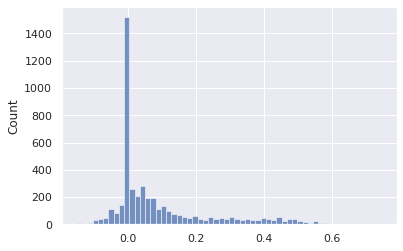

In [20]:
sns.histplot(list(g2.ep['weight']))

In [21]:
# Remove da rede todas as arestas em que weight > higher, conforme feito na aula 8.
def dicotomize(g, higher):
    removed = []

    for e in g.edges():
        if g.ep['weight'][e] > higher:
            removed.append(e)

    for e in removed:
        g.remove_edge(e)

In [22]:
dicotomize(g2, 0.2)

In [23]:
p = draw_gt.sfdp_layout(g2)
move_gt(g2, p)
save_gt(g2, 'example.net.gz')
r = netpixi.render('example.net.gz', infinite=True)

In [24]:
r.graph(kscale=5) # Isto aumenta o tamanho dos nomes.
r.vertex_default(size=6)
r.vertex_set_key('nome')
r.edge_scale('weight', 1, 3)

In [25]:
#identificando core e periphery continuo

matrix = spectral.adjacency(g2)

# Além de cpnet.LowRankCore, há outras
# opções de algoritmos contínuos:
# cpnet.Rombach
# cpnet.Rossa

algorithm = cpnet.MINRES()
algorithm.detect(matrix)
c = algorithm.get_coreness()

# Depois do código acima, c é um dicionário
# em que as chaves são índices de vértices e
# valores são os atribuídos pelo algoritmo.

g2.vp['coreness'] = g2.new_vp('object')
for i, coreness in c.items():
    v = g.vertex(i)
    g2.vp['coreness'][v] = float(coreness)

In [27]:
#juntando informacoes cruciais em um df que contém cada vereador uma vez

final = pd.DataFrame({k: list(v) for k, v in g2.vp.items()})
final = final.dropna()

passed_names=[]
party_size=[]
partido=[]
ideologia=[]

for i, r in clean_df.iterrows():
    if r['vereador'] not in passed_names:
        passed_names.append(r['vereador'])
        party_size.append(r['tamanho partido'])
        partido.append(r['partido'])
        ideologia.append(r['posição política'])

final['partido'] = partido
final['tamanhopartido'] = party_size
final['posiçãopolítica'] = ideologia

final

,id,bipartite,nome,_x,_y,color,coreness,partido,tamanhopartido,posiçãopolítica
0,0,1,ABOU ANNI,4.001395,7.023122,65280,0.948216,PV,7,-0.60
1,1,1,ADILSON AMADEU,7.208241,4.693111,65280,0.786211,PTB,5,0.15
2,2,1,ALESSANDRO GUEDES,4.645011,7.727432,65280,0.403491,PT,14,-0.30
3,3,1,ALFREDINHO,6.690031,5.783671,65280,0.824640,PT,14,-0.30
4,4,1,ANDREA MATARAZZO,3.446020,7.376215,65280,0.332839,PSD,6,0.30
...,...,...,...,...,...,...,...,...,...,...
92,92,1,DANIEL ANNENBERG,5.071296,8.162864,65280,0.566944,PSDB,16,0.60
93,93,1,BETO DO SOCIAL,6.521133,7.166646,65280,0.800581,PSDB,16,0.60
94,94,1,CELSO GIANNAZI,5.027547,9.746625,65280,0.587155,PSOL,4,-0.90
95,95,1,XEXÉU TRIPOLI,1.998516,8.063682,65280,1.083999,PV,7,-0.60


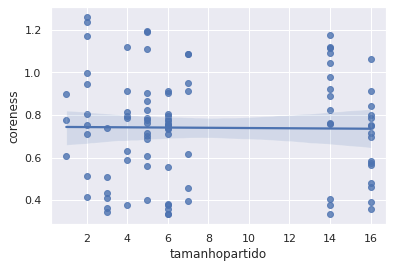

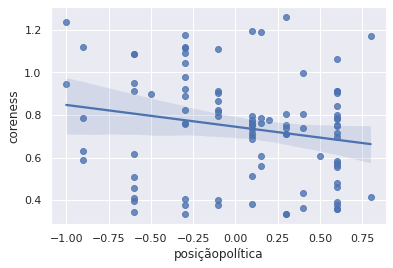

In [28]:
#regressão continua (core periphery) e continua (tamanho de partido)


sns.set()

sns.regplot(x=final['tamanhopartido'], y=final['coreness'])
plt.show()
sns.regplot(x=final['posiçãopolítica'], y=final['coreness'])
plt.show()

In [29]:
model = smf.ols(data=final, formula='coreness ~ tamanhopartido')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               coreness   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                   0.01250
Date:                Mon, 29 Nov 2021   Prob (F-statistic):              0.911
Time:                        22:01:54   Log-Likelihood:                -2.0761
No. Observations:                  97   AIC:                             8.152
Df Residuals:                      95   BIC:                             13.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.7441      0.046     16.050      0.000       0.652       0.836
tamanhopartido    -0.0006      0.005     -0.112      0.911      -0.010       0.009
==============================================================================
Omnibus:                        5.403   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                2.596
Skew:                           0.073   Prob(JB):                        0.273
Kurtosis:                       2.212   Cond. No.                         17.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
model = smf.ols(data=final, formula='coreness ~ posiçãopolítica')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               coreness   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     3.732
Date:                Mon, 29 Nov 2021   Prob (F-statistic):             0.0564
Time:                        22:01:54   Log-Likelihood:               -0.21356
No. Observations:                  97   AIC:                             4.427
Df Residuals:                      95   BIC:                             9.577
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.7448      0.025     29.773      0.000       0.695       0.794
posiçãopolítica    -0.1022      0.053     -1.932      0.056      -0.207       0.003
==============================================================================
Omnibus:                        2.836   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.242   Jarque-Bera (JB):                1.756
Skew:                          -0.015   Prob(JB):                        0.416
Kurtosis:                       2.342   Cond. No.                         2.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""